This notebook has the goal to provide a prediction of the income based on ADULT dataset, taking account of the fairness, not only removing the protected attributes but also the proxies.

In [1]:
import pandas as pd
import sys
import matplotlib.pyplot as plt

In [2]:
sys.path.append('../')

In [3]:
adult_dataset = pd.read_csv('./adult.data', sep=',')

In [4]:
adult_dataset

age         workclass  fnlwgt   education  education-num  \
0       39         State-gov   77516   Bachelors             13   
1       50  Self-emp-not-inc   83311   Bachelors             13   
2       38           Private  215646     HS-grad              9   
3       53           Private  234721        11th              7   
4       28           Private  338409   Bachelors             13   
...    ...               ...     ...         ...            ...   
32556   27           Private  257302  Assoc-acdm             12   
32557   40           Private  154374     HS-grad              9   
32558   58           Private  151910     HS-grad              9   
32559   22           Private  201490     HS-grad              9   
32560   52      Self-emp-inc  287927     HS-grad              9   

           marital-status         occupation   relationship   race     sex  \
0           Never-married       Adm-clerical  Not-in-family  White    Male   
1      Married-civ-spouse    Exec-managerial        Husband  White    Male   
2                Divorced  Handlers-cleaners  Not-in-family  White    Male   
3      Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4      Married-civ-spouse     Prof-specialty           Wife  Black  Female   
...                   ...                ...            ...    ...     ...   
32556  Married-civ-spouse       Tech-support           Wife  White  Female   
32557  Married-civ-spouse  Machine-op-inspct        Husband  White    Male   
32558             Widowed       Adm-clerical      Unmarried  White  Female   
32559       Never-married       Adm-clerical      Own-child  White    Male   
32560  Married-civ-spouse    Exec-managerial           Wife  White  Female   

       capital-gain  capital-loss  hours-per-week native-country income  
0              2174             0              40  United-States  <=50K  
1                 0             0              13  United-States  <=50K  
2                 0             0              40  United-States  <=50K  
3                 0             0              40  United-States  <=50K  
4                 0             0              40           Cuba  <=50K  
...             ...           ...             ...            ...    ...  
32556             0             0              38  United-States  <=50K  
32557             0             0              40  United-States   >50K  
32558             0             0              40  United-States  <=50K  
32559             0             0              20  United-States  <=50K  
32560         15024             0              40  United-States   >50K  

[32561 rows x 15 columns]

After the dataset loading, it's time to perform all the operations on the dataset itself in order to perform the training step and the prediction step on a fair dataset. All the operations needed to guarantee that the resulting dataset is free are encapsulated into the **conscious_fairness_through_unawareness** method.
As reported into the method signature, this one requires some information:
* the dataset
* the list of protected attributes. In this case have been chosen **race**, **sex**, **native-country**
* the values for the output column
* the output column
* the list of possible column to drop. In this case, after a consideration on the relevance of the attributes, have been chosen **capital-gain** and **capital-loss**

In [5]:
from sklearn.preprocessing import LabelEncoder

protected_attributes = ['race', 'sex', 'native-country']
columns_to_drop = ['capital-gain', 'capital-loss']
output_column = 'income'
adult_dataset[output_column] = LabelEncoder().fit_transform(adult_dataset[output_column])
output_column_values = adult_dataset['income'].unique()

In [6]:
from fairness.matching import conscious_fairness_through_unawareness

fair_dataset = conscious_fairness_through_unawareness(adult_dataset, protected_attributes, 
                                                      output_column_values, output_column, 
                                                      columns_to_drop)

unfair


In [7]:
fair_dataset

age  workclass  fnlwgt  education  education-num  hours-per-week  \
0       39          7   77516          9             13              40   
1       50          6   83311          9             13              13   
2       38          4  215646         11              9              40   
3       53          4  234721          1              7              40   
4       28          4  338409          9             13              40   
...    ...        ...     ...        ...            ...             ...   
32556   27          4  257302          7             12              38   
32557   40          4  154374         11              9              40   
32558   58          4  151910         11              9              40   
32559   22          4  201490         11              9              20   
32560   52          5  287927         11              9              40   

       income  
0           0  
1           0  
2           0  
3           0  
4           0  
...       ...  
32556       0  
32557       1  
32558       0  
32559       0  
32560       1  

[32561 rows x 7 columns]

Once we have the fair dataset it's important to move on with the training step and the prediction step

In [8]:
from sklearn.model_selection import train_test_split

X = fair_dataset.drop(columns=['income'], inplace=False)
y = fair_dataset['income']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

After the split of the dataset, the next step is to perform the calculations of the best parameters for the several models we want to use for the prediction step.

In this case we choose the following models: 
* RandomForest Classifier
* Logistic Regression
* DecisionTree Classifier

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

random_forest_model = RandomForestClassifier()
random_forest_params = {'n_estimators': range(10, 100, 10), 'criterion': ['gini', 'entropy', 'log_loss'], 
                        'max_depth': range(10, 50, 10), 'max_leaf_nodes': range(10, 50, 10)}

grid_search = GridSearchCV(random_forest_model, param_grid=random_forest_params, cv=10, return_train_score=True)
random_forest = grid_search.fit(X_train, y_train)

print("The best params for the RandomForest Classifier are: ", random_forest.best_params_)

test_scores = random_forest.cv_results_['mean_test_score']
train_scores = random_forest.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

The best params for the RandomForest Classifier are:  {'criterion': 'gini', 'max_depth': 20, 'max_leaf_nodes': 40, 'n_estimators': 50}


Accuracy for random_forest:  0.7991810906383771


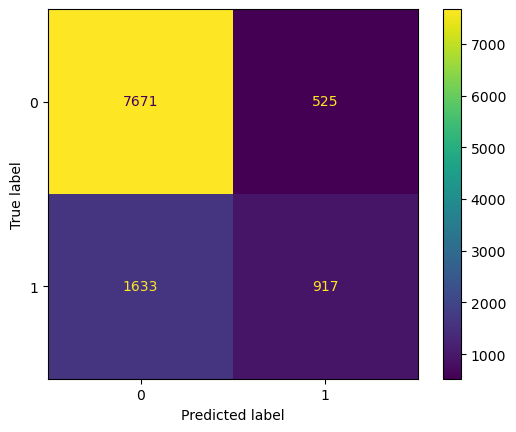

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

predicted_result = random_forest.predict(X_test)
accuracy = accuracy_score(y_test, predicted_result)
print("Accuracy for random_forest: ", accuracy)

matrix = confusion_matrix(y_test, predicted_result, labels=random_forest.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=random_forest.classes_)
display.plot()
plt.show()

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logistic_regression_model = LogisticRegression()
logistic_regression_params = {'penalty': ['l1', 'l2', 'elasticnet'], 'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}

grid_search = GridSearchCV(logistic_regression_model, param_grid=logistic_regression_params, cv=10, return_train_score=True)
logistic_regression = grid_search.fit(X_train, y_train)

print("The best params for the Logistic Regression are: ", logistic_regression.best_params_)

test_scores = logistic_regression.cv_results_['mean_test_score']
train_scores = logistic_regression.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

The best params for the Logistic Regression are:  {'penalty': 'l1', 'solver': 'liblinear'}


In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predicted_result = logistic_regression.predict(X_test)
accuracy = accuracy_score(y_test, predicted_result)
print("Accuracy for logistic regression: ", accuracy)

matrix = confusion_matrix(y_test, predicted_result, labels=logistic_regression.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=logistic_regression.classes_)
display.plot()
plt.show()

Accuracy for logistic regression:  0.7870835659780383


In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

decision_tree_model = DecisionTreeClassifier()
decision_tree_params = {'criterion': ['gini', 'entropy', 'log_loss'], 
                        'max_depth': range(10, 50, 10), 'max_leaf_nodes': range(10, 50, 10)}

grid_search = GridSearchCV(decision_tree_model, param_grid=decision_tree_params, cv=10, return_train_score=True)
decision_tree = grid_search.fit(X_train, y_train)
best_params = decision_tree.best_params_
print("The best params for DecisionTree Classifier are: ", best_params)

test_scores = decision_tree.cv_results_['mean_test_score']
train_scores = decision_tree.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

The best params for DecisionTree Classifier are:  {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 40}


Accuracy for decision tree classifier:  0.7991810906383771


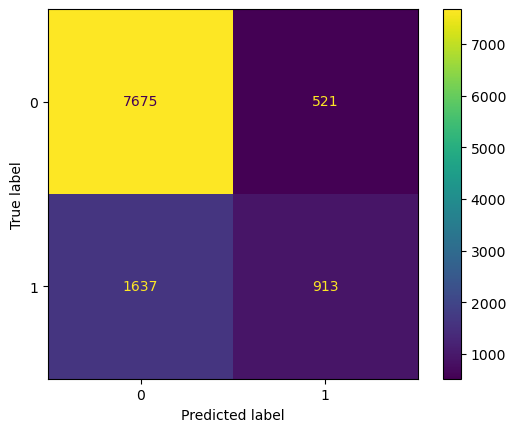

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predicted_result = decision_tree.predict(X_test)
accuracy = accuracy_score(y_test, predicted_result)
print("Accuracy for decision tree classifier: ", accuracy)

matrix = confusion_matrix(y_test, predicted_result, labels=decision_tree.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=decision_tree.classes_)
display.plot()
plt.show()